# Dependencies

In [ ]:
using Pkg
Pkg.activate(".")

In [ ]:
using LinearAlgebra
using Turing
using LimberJack
using MicroCanonicalHMC
using CSV
using DataFrames
using YAML
using NPZ
using JLD2
using PythonCall
using Statistics
using StatsPlots
sacc = pyimport("sacc");

# Data

In [43]:
method = "bpz"
sacc_path = "../data/CosmoDC2/summary_statistics_fourier_tjpcov.sacc"
yaml_path = "../data/CosmoDC2/gcgc.yml"
nz_path = string("../data/CosmoDC2/image_nzs_", method, "_priors/")
dz_path = string("../data/CosmoDC2/image_dz_", method, "_priors/dz_prior.npz")

sacc_file = sacc.Sacc().load_fits(sacc_path)
yaml_file = YAML.load_file(yaml_path)

nz_lens_0 = npzread(string(nz_path, "nz_lens_0.npz"))
nz_lens_1 = npzread(string(nz_path, "nz_lens_1.npz"))
nz_lens_2 = npzread(string(nz_path, "nz_lens_2.npz"))
nz_lens_3 = npzread(string(nz_path, "nz_lens_3.npz"))
nz_lens_4 = npzread(string(nz_path, "nz_lens_4.npz"))
zs_k0, nz_k0 = nz_lens_0["z"], nz_lens_0["dndz"]
zs_k1, nz_k1 = nz_lens_1["z"], nz_lens_1["dndz"]
zs_k2, nz_k2 = nz_lens_2["z"], nz_lens_2["dndz"]
zs_k3, nz_k3 = nz_lens_3["z"], nz_lens_3["dndz"]
zs_k4, nz_k4 = nz_lens_4["z"], nz_lens_4["dndz"]
mu_k0 = sum(zs_k0 .* nz_k0) / sum(nz_k0)
mu_k1 = sum(zs_k1 .* nz_k1) / sum(nz_k1)
mu_k2 = sum(zs_k2 .* nz_k2) / sum(nz_k2)
mu_k3 = sum(zs_k3 .* nz_k3) / sum(nz_k3)
mu_k4 = sum(zs_k4 .* nz_k4) / sum(nz_k4)

dz_prior = npzread(dz_path)
dz_mean, dz_cov = dz_prior["mean"], dz_prior["cov"]
dz_mean = dz_mean[11:20]
dz_cov = dz_cov[11:20, 11:20]
dz_chol = cholesky(dz_cov).U'

meta, files = make_data(sacc_file, yaml_file;
                        nz_lens_0=nz_lens_0,
                        nz_lens_1=nz_lens_1,
                        nz_lens_2=nz_lens_2,
                        nz_lens_3=nz_lens_3,
                        nz_lens_4=nz_lens_4)

meta.types = [ 
    "galaxy_density",
    "galaxy_density",
    "galaxy_density",
    "galaxy_density",
    "galaxy_density"]

cov = meta.cov
Γ = sqrt(cov)
iΓ = inv(Γ);

lens_0 lens_0 8
lens_1 lens_0 8
lens_1 lens_1 9
lens_2 lens_0 8
lens_2 lens_1 9
lens_2 lens_2 10
lens_3 lens_0 8
lens_3 lens_1 9
lens_3 lens_2 10
lens_3 lens_3 11
lens_4 lens_0 8
lens_4 lens_1 9
lens_4 lens_2 10
lens_4 lens_3 11
lens_4 lens_4 11
using custom nz for nz_lens_0
using custom nz for nz_lens_1
using custom nz for nz_lens_2
using custom nz for nz_lens_3
using custom nz for nz_lens_4


# Model

In [49]:
function make_theory(;Ωm=0.27347, σ8=0.779007, Ωb=0.04217, h=0.71899, ns=0.99651,
     meta=meta, files=files)
     nuisances = Dict(
        "lens_0_b"    => 0.879118,
        "lens_1_b"    => 1.05894,
        "lens_2_b"    => 1.22145,
        "lens_3_b"    => 1.35065,
        "lens_4_b"    => 1.58909)
        
    cosmology = Cosmology(Ωm=Ωm, Ωb=Ωb, h=h, ns=ns, σ8=σ8,
            tk_mode=:EisHu,
            pk_mode=:Halofit)

    return Theory(cosmology, meta, files; Nuisances=nuisances)
end

make_theory (generic function with 8 methods)

In [59]:
fake_data = make_theory();
fake_data = iΓ * fake_data
data = fake_data

139-element Vector{Float64}:
  0.8665730103575667
  1.80379398156211
  2.9980758404831884
  5.14940568396759
 10.140646913530178
 18.84614591199148
 34.72637080854234
 56.92193845764497
  0.20474798058864221
  0.35264942062267685
  0.4066054898956868
  0.3821565415625734
  0.04750399368172381
  ⋮
  2.2420285926276113
  0.8032341393476702
  1.4855537626020234
  2.147921545835163
  3.113600736780586
  4.758815429506602
  6.7765337121055715
  9.663919516582965
 13.974499087286295
 19.950210681506764
 28.34733882496198
 39.92004235958697

In [74]:
@model function model(data)
    Ωm ~ Uniform(0.2, 0.6)
    Ωbb ~ Uniform(0.28, 0.65) # 10*Ωb 
    Ωb := 0.1*Ωbb 
    h ~ Truncated(Normal(0.72, 0.05), 0.64, 0.82)
    σ8 ~ Uniform(0.4, 1.2)
    ns ~ Uniform(0.84, 1.1)

    theory := make_theory(Ωm=Ωm, Ωb=Ωb, h=h, σ8=σ8, ns=ns)
    ttheory = iΓ * theory
    d = fake_data - ttheory
    Xi2 := dot(d, d)
    data ~ MvNormal(ttheory, I)
end


model (generic function with 2 methods)

# Settings

In [82]:
iterations = 2000
adaptation = 500
TAP = 0.65

println("sampling settings: ")
println("iterations ", iterations)
println("TAP ", TAP)
println("adaptation ", adaptation)
#println("nchains ", nchains)

# Start sampling.
folpath = "../chains_test/"
folname = string("CosmoDC2_gcgc_nomarg_TAP_", TAP)
folname = joinpath(folpath, folname)

if isdir(folname)
    fol_files = readdir(folname)
    println("Found existing file ", folname)
    if length(fol_files) != 0
        last_chain = last([file for file in fol_files if occursin("chain", file)])
        last_n = parse(Int, last_chain[7])
        #println("Restarting chain")
    else
        #println("Starting new chain")
        last_n = 0
    end
else
    mkdir(folname)
    println(string("Created new folder ", folname))
    last_n = 0
end

# Create a placeholder chain file.
CSV.write(joinpath(folname, string("chain_", last_n+1,".csv")), Dict("params"=>[]), append=true)

sampling settings: 
iterations 2000
TAP 0.65
adaptation 500
Found existing file ../chains_test/CosmoDC2_gcgc_nomarg_TAP_0.65


"../chains_test/CosmoDC2_gcgc_nomarg_TAP_0.65/chain_1.csv"

# Sample

In [83]:
cond_model = model(data)
mchmc = MCHMC(2_000, 10.0;
    L=100.0, 
    tune_L=false, 
    tune_sigma=false,
    adaptive=true)
espl = externalsampler(mchmc)
chain = sample(cond_model, espl, 18_000;
                #init_params=init_params,
                progress=true, save_state=true);


┌ Warning: ProgressMeter by default refresh meters with additional information in IJulia via `IJulia.clear_output`, which clears all outputs in the cell. 
│  - To prevent this behaviour, do `ProgressMeter.ijulia_behavior(:append)`. 
│  - To disable this warning message, do `ProgressMeter.ijulia_behavior(:clear)`.
└ @ ProgressMeter ~/.julia/packages/ProgressMeter/kVZZH/src/ProgressMeter.jl:594
Tuning: 100%|███████████████████████████████████████████| Time: 0:02:03
  ϵ:     0.03769773768138591
  L:     100.0
  dE/d:  0.3774905413327133
Sampling:  54%|██████████████████████▏                  |  ETA: 0:11:33

In [77]:
chain[:Xi2]

2-dimensional AxisArray{Float64,2,...} with axes:
    :iter, 1:1:1000
    :chain, 1:1
And data, a 1000×1 Matrix{Float64}:
  7.6782585624351425
 34.43256446998382
  7.633876180824029
 34.22926491168417
  7.605257612412045
 35.54242345251476
  7.5631720788229035
 35.35707239022974
  7.537014921833588
 36.66797439823746
  7.511423217470376
 36.511660424845665
  7.488440466252825
  ⋮
  0.7569924000204663
 29.891370126852756
  0.13832850785114656
 33.323947161832045
  0.13078528919579988
 31.31694186358123
  0.9097350474990579
 34.95779093297971
  0.894476087984752
 32.51968390722791
  0.1367117338601652
 36.539440727199576

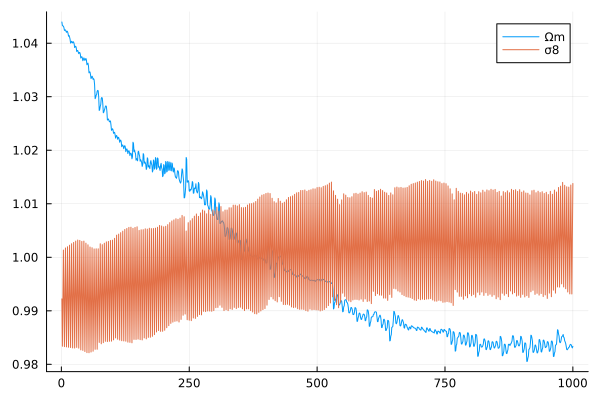

In [79]:
plot(chain["Ωm"]/mean(chain["Ωm"]), label="Ωm")
plot!(chain["σ8"]/mean(chain["σ8"]), label="σ8")

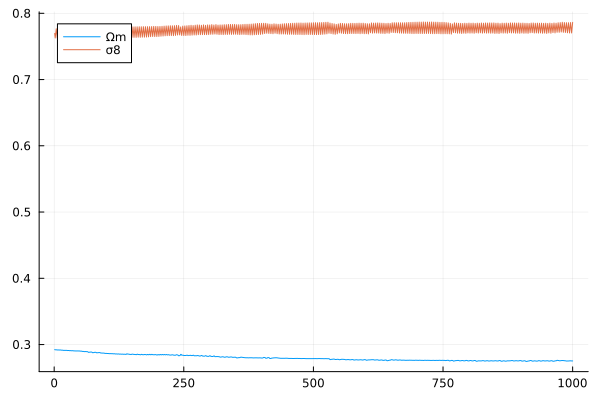

In [80]:
plot(chain["Ωm"], label="Ωm")
plot!(chain["σ8"], label="σ8")

In [81]:
# Save the actual chain.       
@save joinpath(folname, string("chain_", last_n+1,".jls")) chain
CSV.write(joinpath(folname, string("chain_", last_n+1,".csv")), chain)
CSV.write(joinpath(folname, string("summary_", last_n+1,".csv")), describe(chain)[1])

┌ Warning: Attempting to store typeof(model).
│  Function types cannot be propertly stored in JLD2 files.
│  Loading may yield unexpected results.
└ @ JLD2 ~/.julia/packages/JLD2/JHhTf/src/data/writing_datatypes.jl:631
┌ Warning: Attempting to store typeof(identity).
│  Function types cannot be propertly stored in JLD2 files.
│  Loading may yield unexpected results.
└ @ JLD2 ~/.julia/packages/JLD2/JHhTf/src/data/writing_datatypes.jl:631
┌ Warning: Attempting to store ComposedFunction{Accessors.IndexLens{Tuple{Int64}}, typeof(identity)}.
│  Function types cannot be propertly stored in JLD2 files.
│  Loading may yield unexpected results.
└ @ JLD2 ~/.julia/packages/JLD2/JHhTf/src/data/writing_datatypes.jl:631
┌ Warning: Attempting to store typeof(MicroCanonicalHMC.Leapfrog).
│  Function types cannot be propertly stored in JLD2 files.
│  Loading may yield unexpected results.
└ @ JLD2 ~/.julia/packages/JLD2/JHhTf/src/data/writing_datatypes.jl:631
┌ Warning: Attempting to store typeof(MicroC

"../chains_test/CosmoDC2_gcgc_nomarg_TAP_0.65/summary_10.csv"